In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 04: Seleção de modelo e hiperparametros

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [11]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)


In [12]:
def linear_regression(X, y, c):
    X = np.c_[np.ones(X.shape[0]), X]
    n, m = X.shape
    I = np.eye(m)
    w = np.linalg.solve(X.T @ X + c * I, X.T @ y)
    return w

def mse(y, y_pred):
    return np.mean((y - y_pred) ** 2)

def predict(X, w):
    X = np.c_[np.ones(X.shape[0]), X]
    return X @ w


In [13]:
c_values = np.logspace(-10,4, num=10000)
mse_val = []
mse_train = []
for c in c_values:
    w = linear_regression(X_train, y_train, c)
    y_val_pred = predict(X_val, w)
    y_train_pred = predict(X_train, w)
    mse_val.append(mse(y_val, y_val_pred))
    mse_train.append(mse(y_train, y_train_pred))


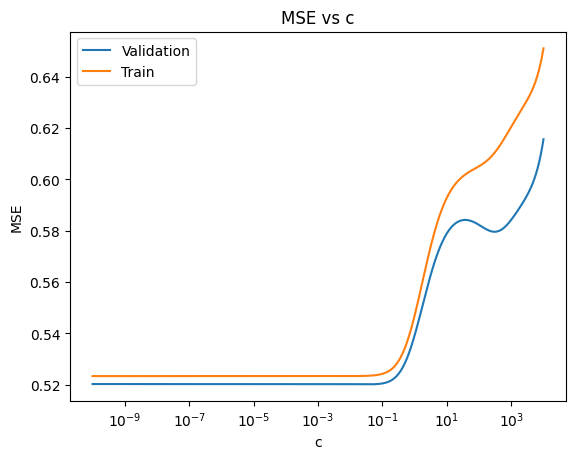

In [14]:
plt.plot(c_values, mse_val)
plt.plot(c_values, mse_train)
plt.xscale('log')
plt.xlabel('c')
plt.ylabel('MSE')
plt.legend(['Validation', 'Train'])
plt.title('MSE vs c')
plt.show()

**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*. 

In [15]:
c_v = [0, 1, 10, 100]

def split_folds(X, y, k):
    np.random.shuffle([X,y])
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    return X_folds, y_folds


X_folds, y_folds = split_folds(X, y, 5)
mse_knn = []
mse_lr = []
mse_knn_folds = []
mse_lr_folds = []
for i in range(5):
    X_test_fold = X_folds[i]
    y_test_fold = y_folds[i]
    for j in range(5):
        if j != i:
            X_train_fold = [X_folds[l] for l in range(5) if l != i and l != j]
            y_train_fold = [y_folds[l] for l in range(5) if l != i and l != j]
            X_train_fold = np.concatenate(X_train_fold)
            y_train_fold = np.concatenate(y_train_fold)
            X_val_fold = X_folds[j]
            y_val_fold = y_folds[j]
            mse_knn_temp = []
            for k in range(1,5):
                knn = KNeighborsRegressor(n_neighbors=k)
                knn.fit(X_train_fold, y_train_fold)
                y_val_pred = knn.predict(X_val_fold)
                mse_knn_temp.append(mse(y_val_fold, y_val_pred))
            mse_knn_folds.append(mse_knn_temp)
            
            mse_lr_temp = []
            for c in c_v:
                w = linear_regression(X_train_fold, y_train_fold, c)
                y_val_pred = predict(X_val_fold, w)
                mse_lr_temp.append(mse(y_val_fold, y_val_pred))
            mse_lr_folds.append(mse_lr_temp)
    min_folds_knn = np.argmin(np.mean(mse_knn_folds, axis=0))+1
    min_folds_lr = c_v[np.argmin(np.mean(mse_lr_folds, axis=0))]
    X_train = [X_folds[l] for l in range(k) if l != i]
    y_train = [y_folds[l] for l in range(k) if l != i]
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    knn = KNeighborsRegressor(n_neighbors=min_folds_knn)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test_fold)
    mse_knn.append((mse(y_test_fold, y_test_pred), min_folds_knn))
    w = linear_regression(X_train, y_train, min_folds_lr)
    y_test_pred = predict(X_test_fold, w)
    mse_lr.append((mse(y_test_fold, y_test_pred), min_folds_lr))            

In [16]:
print('MSE knn:', mse_knn)
print('MSE lr:', mse_lr)

MSE knn: [(1.1989489668675235, 4), (1.1703666935953714, 4), (1.538374930076944, 4), (1.2954927741888096, 4), (1.4749280826539184, 4)]
MSE lr: [(0.6826392855190764, 0), (0.618253118908901, 0), (0.6498530168444859, 0), (0.5764954482081415, 0), (0.49468483563906523, 0)]


# Exercício de "papel e caneta"

**1.** Nas nota de aula, derivamos o "dilema viés-variância" calculando o MSE esperado entre a função alvo de aprendizado $f$ e a predição do nosso modelo $h_{\mathcal{D}}$:

$$
\mathbb{E}_{x, \mathcal{D}} 
    \left[ 
        \left( 
        h_{\mathcal{D}}(x) - f\left(x\right) 
        \right)^2
    \right] =
\mathbb{E}_{x}[\underbrace{\textrm{Var}_{\mathcal{D}}[
        h_{\mathcal{D}}(x)]}_{\text{ Variância} }] + \mathbb{E}_{x} [ (\underbrace{\mathbb{E}_{\mathcal{D}}[
        h_{\mathcal{D}}(x) - f\left(x\right)]  }_{\text{Viés}})^2] 
    ].
$$

Com isso em mente, adapte nossa derivação para o caso em que as respostas de teste $f(x)$ são corrompidas por um ruído aditivo aleatório $\epsilon$ com média zero, i.e., observamos $f^\prime(x) = f(x) + \epsilon$. Mais concretamente, trabalhe a seguinte esperança para derivar uma decomposição similar à da nota de aula:
$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right)
        \right)^2
    \right].
$$

Compare a diferença entre a decomposição que você obteve e a da nota de aula.

Dica: sua decomposição deve se diferenciar da acima em apenas um termo aditivo, que envolve uma esperança sobre $x$ e $y$.


### Resposta

$$
\begin{aligned}
\mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f^\prime\left(x\right)\right)^2\right] &= \mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right) - \epsilon\right)^2\right]\\ 
&= \mathbb{E}_{x, \epsilon, \mathcal{D}} \left[h_{\mathcal{D}}(x)^2 + f\left(x\right)^2 + \epsilon^2 - 2h_{\mathcal{D}}(x)f\left(x\right) - 2h_{\mathcal{D}}(x)\epsilon + 2f(x)\epsilon\right]\\
&= \mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)^2 - 2\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)\epsilon + \epsilon^2\right]\\
&= \mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)^2\right] - 2\mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)\epsilon\right] + \mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\epsilon^2\right]\\
&= \mathbb{E}_{x, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)^2\right] - 2\mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)\epsilon\right] + \mathbb{E}_{\epsilon} \left[\epsilon^2\right]\\
\end{aligned}
$$
\
Assumindo que $\epsilon\mathbb{\perp} f(x),h_{\mathcal{D}}(x)$:
$$\mathbb{E}_{x, \epsilon, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f^\prime\left(x\right)\right)^2\right]=\mathbb{E}_{x, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)^2\right] - 2\mathbb{E}_{x, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)\right]\mathbb{E}_{\epsilon}[\epsilon] + \mathbb{E}_{\epsilon} \left[\epsilon^2\right]$$
como $\mathbb{E}_{\epsilon}[\epsilon] = 0$, temos:
$$\mathbb{E}_{x, \mathcal{D}} \left[\left( h_{\mathcal{D}}(x) - f\left(x\right)\right)^2\right] + \mathbb{E}_{\epsilon} \left[\epsilon^2\right]
$$